### Bacterial regions

Input files:<br>
Spots in tissue section, output from Celery: Bacs_Tissue_Reg_annotations.txt<br>
Annotation files GF / SPF: $*$annotations.txt<br>
Anndata file: anndata_hm_norm_all_de_genes_n_Feb2022.h5ad<br>


In [1]:
from __future__ import absolute_import, division, print_function

import os
import re
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
from scipy.cluster.hierarchy import dendrogram
import sklearn
import scanpy.external as sce
import matplotlib.cm as cm
import warnings
from sklearn import preprocessing
import networkx as nx
import operator as op
import math
from collections import Counter, defaultdict
import numbers
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams.update({'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial',
                            'patch.edgecolor' : 'black'})
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=15, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

In [2]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def calc_euclidean_dist(row, centerx, centery):
    point = np.array((row['x'], row['y']))
    cent = np.array((centerx, centery))
 
    # calculating Euclidean distance
    dist = np.linalg.norm(point - cent)
    
    return dist

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

def random_color():
    oo = np.random.choice(range(256), size=3)
    oo = [int(i) for i in oo]
    return tuple(oo)

def get_tissue_weights_bac(a, gene = None, region = None, age = None, ):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    plot_type - str - needs to match 'major' or 'minor'
    ** kwargs:
    key = 'annotation_analysis'
    plot_type = 'major'
    plot_values = 'modules'
    gene = ['Epcam']
    region = ['GT']
    age = ['6w']
    '''
    
    # check if key exhists
    for_keys = gene
    
    
    a_pd_mean_list = []
    for cluster_idx in for_keys:

        #Get genes per cluster
        a_cluster = a.copy()
        genes_cluster = cluster_idx
        a_cluster = a_cluster[:,str(genes_cluster)]

        # subset to appropriate ages
        if (gene != None):
            if (region != None):
                print("Subsetting to specific genotype...")
                a_cluster = a_cluster[a_cluster.obs.Genotype.isin(region)]
                width_fig = 5
            else:
                width_fig = 3

        # Scale data
        if gene != ['total_sum']:
            #Make sure anndata has the genes subsetted in this module aka cluster                        
            a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)

        else:
            a_scaled = a_cluster.obs.total_counts

        a_anns = a_cluster.obs.annotation
        a_conds = a_cluster.obs.conditions

        #Group anndata by condition and annotations
        a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
        a_pd.columns = ["annotation", "conditions", "value"]
        a_pd.value = a_pd.value.astype(float)
        a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()

        anns_counts = a_cluster.obs.groupby(["annotation", "conditions"]).count()
        gf_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'GF_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][0]
        wt_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'WT_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][1]
        w = pd.DataFrame(pd.concat([gf_perc,wt_perc])['sample'])
        w = w.reindex(a_pd_mean.index)
        w.columns = ['value']
        a_pd_mean['value'] = [i*j for i,j in zip(a_pd_mean['value'],w['value'])]            

        # set unique variables for plotting
        ages = np.unique([i.split("_")[1] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])
        ages = [str(j)+'w' for j in sorted([int(i.split('w')[0]) for i in ages])]
        regions = np.unique([i.split("_")[0] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])

        # use the same color scale across the arrays
        a_pd_mean= a_pd_mean.round(2)
        vmin = 0.01*a_pd_mean.values.max()
        vmax = 0.99*a_pd_mean.values.max()
        a_pd_mean[a_pd_mean < vmin ] = 0
        a_pd_mean[a_pd_mean > vmax ] = vmax
        a_pd_mean.rename(columns = {'value':cluster_idx}, inplace=True)
        
        a_pd_mean_list.append(a_pd_mean[cluster_idx])

    return pd.DataFrame(a_pd_mean_list)

def region_and_bacterial_filtering(a):
    
    pop = pd.DataFrame(a.X, columns=a.var_names, index=a.obs['annotation'])
    
    #### REGIONAL FILTERING ######
    # Weighten mean
    pop = get_tissue_weights_bac(a, gene = a.var_names.tolist())
    pop = pop.T
    pop.reset_index(inplace = True)
    obs = pop[['annotation', 'conditions']]
    pop = pop.iloc[:,2:]
    pop.columns = a.var_names.tolist()

    alla = sc.AnnData(X=pop, obs=obs)
    axgf = alla[alla.obs.conditions == 'GF_6w']

    # FILTER
    bac_regions = ['mucosa and pellet','pellet','crypt apex and crypt mid','crypt apex and mucosa', 'crypt base','crypt mid']
    popcopy = pop.copy()
    popcopy.index = obs.annotation

    total_bac_exp = np.sum(alla.X.sum())

    region_l = []
    for regionl in obs.annotation.unique():
        popcopy_region = popcopy[popcopy.index == regionl]

        if regionl in bac_regions:    
            cutiff = 0.3*np.max(pd.DataFrame(axgf.X).max())
        else:
            cutiff = 1*np.max(pd.DataFrame(axgf.X).max())

        popcopy_region[popcopy_region < cutiff] = 0 

        axgf_regional_bac_exp = popcopy_region.iloc[0,:].sum()
        axwt_regional_bac_exp = popcopy_region.iloc[1,:].sum()

        axgf_regional_bac = popcopy_region.iloc[0,:]
        axwt_regional_bac = popcopy_region.iloc[1,:]

        if not axwt_regional_bac_exp/total_bac_exp > 0.02:
            axwt_regional_bac[axwt_regional_bac > 0] = 0 
        if not axgf_regional_bac_exp/total_bac_exp > 0.02:
            axgf_regional_bac[axgf_regional_bac > 0] = 0

        popcopy_region = pd.concat([axgf_regional_bac, axwt_regional_bac], axis=1).T

        region_l.append(popcopy_region)

    regional_df = pd.concat(region_l)
    regional_df.reset_index(inplace=True)
    regional_df.drop(columns='index', inplace=True)

    if 'level_0' in list(regional_df):
        regional_df.drop(columns=['level_0'], inplace=True)
    
    alla = sc.AnnData(X=regional_df, obs=obs)
    
    #### BACTERIAL FILTERING #####
    bac_filt_l = []
    for genes_cluster in alla.var_names.unique():

        a_cluster = alla[:,np.intersect1d(genes_cluster,alla.var_names)]

        # Scale data                      
        a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)
        a_anns = a_cluster.obs.annotation
        a_conds = a_cluster.obs.conditions

        #Group anndata by condition and annotations
        a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
        a_pd.columns = ["annotation", "conditions", "value"]
        a_pd.value = a_pd.value.astype(float)
        a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()

        gf_co = a_pd_mean[a_pd_mean.index.get_level_values(1) == 'GF_6w']
        for regionn in a_pd_mean.index.get_level_values(0).unique():
            cutiff = 1*np.max(gf_co[gf_co.index.get_level_values(0) == regionn]['value'])
            a_pd_mean[a_pd_mean < cutiff] = 0
        a_pd_mean.rename(columns={'value':genes_cluster}, inplace=True)

        bac_filt_l.append(a_pd_mean)

    allap = pd.concat([l.iloc[:,0] for l in bac_filt_l], axis=1)
    allap[allap <0] = 0
    allap_wt = allap[allap.index.get_level_values(1) == 'WT_6w']
    
    return allap_wt

    
    

# Read annotation files


In [4]:
# Read tissue section file
marked_tissue_file = 'Bacs_Tissue_Reg_annotations.txt'

marked_tissues = pd.read_csv(marked_tissue_file, sep='\t')
marked_tissues.rename(columns={'value':'annotation'}, inplace=True)


In [5]:
# Read annotation files
path = ''
annot_l = []
region_list = []
for filename in glob.glob(os.path.join(path, '*annotations.txt')):
    
    name = filename.split('/')[-1].split('_annotations.txt')[0]
    
    if name.startswith('10015'):
    
        # Read file
        annot = pd.read_csv(filename, sep='\t')
        annot.rename(columns={'value':'annotation'}, inplace=True)

        annot_melt = pd.melt(annot, id_vars=['annotation'], value_vars=['x_y'])

        annot_melt[['x', 'y']] = annot_melt["value"].str.split("_", n = 1, expand = True)

        annot_melt[['x', 'y']] = annot_melt[['x', 'y']].astype(int)
        annot_melt = annot_melt[annot_melt['value'] != 0]

        #merge with marked_tissues
        if name in marked_tissues['image'].tolist():
            marked_tissues_samp = marked_tissues[marked_tissues['image'] == name]
            annot_melt = annot_melt.merge(marked_tissues_samp, how='inner', left_on='value', right_on='x_y')    
            annot_melt = annot_melt.loc[:,['annotation_x', 'variable', 'value', 'x_x', 'y_x', 'annotation_y']]
            annot_melt.rename(columns={'annotation_x':'annotation',
                                      'annotation_y':'section',
                                      'x_x':'x',
                                      'y_x':'y',
                                      'value':'xy'}, inplace=True)
            annot_melt['name'] = name

            # Get the regions
            for reg in annot_melt['annotation'].tolist():
                region_list.append(reg)

            annot_l.append(annot_melt)

df = pd.concat(annot_l)


In [6]:
interesting_regions = ['externa', 'externa and interna', 'interna', 'epithelium and muscle and submucosa',
       'mucosae and interna', 'epithelium',
       'crypt base', 'epithelium and mucosae',
       'epithelium and mucosae and submucosa', 'crypt mid',
       'crypt apex and crypt mid', 'crypt apex and mucosa',
       'mucosa and pellet', "peyer's patch", 'pellet']


# Calculate distance to centroid per section and spot
dist_l = []

for label, group in df.groupby(['name', 'section']):
    
    # Calculate centroid
    centerx, centery = centeroidnp(np.array(group.loc[:,['x', 'y']]))
    
    # For each spot calculate the euclidean distance to the centroid
    group['euclidean dist'] = group.apply(lambda row: calc_euclidean_dist(row, centerx, centery), axis=1)

    dist_l.append(group)
    
dist = pd.concat(dist_l)
dist = dist[dist['annotation'].isin(interesting_regions)]

# Calculate mean euclidean distance per region
dist_region_mean = dist.groupby('annotation').mean()[['euclidean dist']].sort_values(by='euclidean dist', ascending=False).index


In [7]:
short_annotations_d = {'pellet': 'PE', 'epithelium': 'E', 'crypt apex and mucosa': 'APEXMU', 
                       'crypt base': 'BASE', 'epithelium and mucosae and submucosa': 'EMMSUB', 
                       'epithelium and muscle and submucosa': 'ALL', 'mucosa and pellet': 'MUPE', 
                       'externa': 'ME', 'crypt mid': 'MID', 'muscle and submucosa': 'MSUB', 
                       'crypt apex and crypt mid': 'UPPERMID', 'epithelium and mucosae': 'EMM', 
                       'externa and interna': 'MEI', 'interna': 'MI', 'mucosae and interna': 'MMI', 
                       "peyer's patch": 'PP'}
dist['short_annotations'] = dist['annotation'].map(short_annotations_d)


In [8]:
# Mean euclidean distance per region type
dd = defaultdict(list)
dist_mean = dist.groupby('annotation').mean()[['euclidean dist']]
dist_mean = dist_mean[dist_mean.index.isin(interesting_regions)]

dist_mean_d = dist_mean.reset_index()

# Define the sorter
sorter = ['mucosa and pellet', 'pellet', 'crypt apex and mucosa', 'crypt apex and crypt mid', 
          'crypt base', 'crypt mid','epithelium and mucosae', 'epithelium and mucosae and submucosa',
          'epithelium and muscle and submucosa', 'externa', 'externa and interna', 'interna', 'mucosae and interna',
          'muscle and submucosa', "peyer's patch"]

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(sorter, range(len(sorter))))

# Generate a rank column that will be used to sort
# the dataframe numerically
dist_mean_d['Rank'] = dist_mean_d['annotation'].map(sorterIndex)

dist_mean_d.sort_values(['Rank'], ascending = [True], inplace = True)
dist_mean_d.set_index('Rank', inplace = True)

dist_mean_d = dict(dist_mean_d.loc[:, 'annotation'].to_dict(dd))


In [10]:
# Read anndata file

tx_order = ['genus', 'family', 'order', 'class', 'phylum']
bac_regions = ['pellet', 'mucosa and pellet', 'crypt apex and mucosa', 'crypt base', 'crypt mid', 'crypt apex and crypt mid']

####### WEIGHTED MEAN #######

path = ''
fa = sc.read_h5ad(os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad'))
fa.obs['Age'] = '6w'
fa.obs['conditions'] = [i+"_"+str(j) for i,j in zip(fa.obs.Genotype, fa.obs.Age)]

# Only bacteria 
a = fa[:, fa.var_names.isin([i for i in fa.var_names if 'Bacteria' in i])]

# Change names of some bacteria
new_gene_names_in_correct_order = ['Massilistercora-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Massilistercora-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in a.var_names]
new_gene_names_in_correct_order = ['Intestinimonas-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Intestinimonas-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in new_gene_names_in_correct_order]
a.var_names = new_gene_names_in_correct_order
bac_names = [i for i in a.var.index if i.endswith('Bacteria')]
bac_names = [i for i in bac_names if i not in ['Lacrimispora-Lachnospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria',
                                   'Acetobacterium-Eubacteriaceae-Eubacteriales-Clostridia-Firmicutes-Bacteria']]

a = a[:, a.var_names.isin(bac_names)]


In [11]:
##### FILTERING ######
allap_wt = region_and_bacterial_filtering(a)


In [12]:
bf_bacs_num = {}
top5bac_d = {}
top5bac_fracs_d = {}

for annot in allap_wt.index.unique():

    lsub = allap_wt.loc[annot,:]
    lsub = lsub[lsub!=0]

    for k,v in dist_mean_d.items():
        if v == annot:
            aar = k

    # Num bacs per region
    bac_count = len(lsub)

    if bac_count == 0:
        continue
        
    bf_bacs_num[annot[0]] = bac_count
    
    lsubg = lsub.sort_values(ascending=False).head(3)

    top5bac_d[annot[0]] = dict(Counter(lsubg.index.tolist()))
    
    top5bac_fracs_d[annot[0]] = [i/sum(lsubg.tolist()) for i in lsubg.tolist()]


In [13]:
# Pair region with bac_num
region_numbac_d = {}
for k,v in dist_mean_d.items():
    try:
        region_numbac_d[k] = bf_bacs_num[v]
    except KeyError:
        continue
        region_numbac_d[k] = 'Nan'


In [14]:
# Calculate abs distance between regions
node_df = pd.DataFrame(abs(dist_mean['euclidean dist'].values - dist_mean['euclidean dist'].values[:, None])).stack().reset_index() 
node_df.columns=['n1', 'n2', 'euclidean dist']
node_df = node_df[node_df['euclidean dist'] != 0]

# Scale
node_df['euclidean dist.scale'] = node_df['euclidean dist'].values.max() + 1 - node_df['euclidean dist']
node_df[['euclidean dist.scale']] = node_df[['euclidean dist.scale']].transform(lambda x: preprocessing.minmax_scale(x, feature_range=(1,5)))
node_df['euclidean dist.scale'] = np.exp(node_df['euclidean dist.scale']) / 10

node_df = node_df[(node_df.n1.isin(region_numbac_d.keys())) & (node_df.n2.isin(region_numbac_d.keys()))]


# Plot number of genera in each region

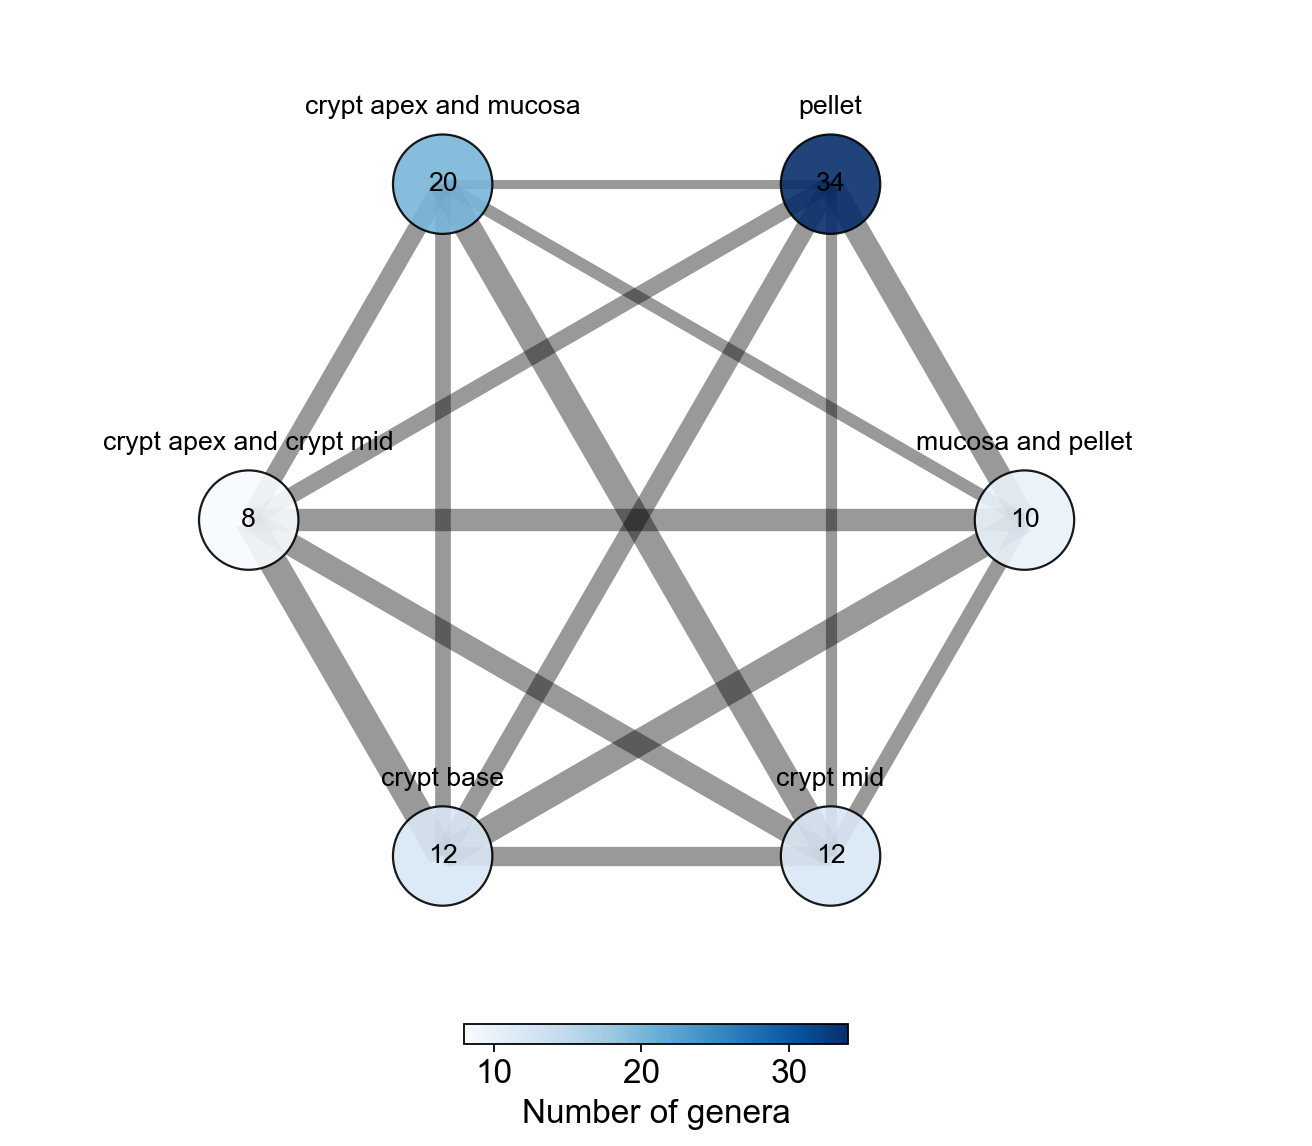

In [15]:
G = nx.from_pandas_edgelist(node_df, 'n1', 'n2', edge_attr ='euclidean dist.scale')

# Color nodes
colors = ['rosybrown', 'salmon', 'peru',  'olive', 'palegreen', 'mediumseagreen', 'teal', 'powderblue', 'slategrey', 'mediumpurple']
color_map = []
ColorLegend = {}
for node in G:
    node_name = dist_mean.index.tolist()[node]
    if len(node_name.split(' ')) > 10:
        node_name = ' '.join(node_name.split(' ')[0:5]) + '\n' + ' '.join(node_name.split(' ')[6:12]) + '\n' + ' '.join(node_name.split(' ')[12:])
    elif len(node_name.split(' ')) > 5:
        node_name = ' '.join(node_name.split(' ')[0:5]) + '\n' + ' '.join(node_name.split(' ')[6:])

widths = nx.get_edge_attributes(G, 'euclidean dist.scale')

dist_mean_d_sub = {key: dist_mean_d[key] for key in region_numbac_d.keys()}

nodelist = G.nodes()

# Plot
f = plt.figure(figsize=(8,8))
ax=plt.axes([0,0,1,1])

ax.set_aspect('equal')

region_numbac_d_values = [region_numbac_d.get(node, 0.25) for node in G.nodes()]

pos = nx.circular_layout(G)
pos_nodes = nudge(pos, 0, 0.2)  
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=2000,
                       node_color=region_numbac_d_values,
                       alpha=0.9,
                      cmap=plt.get_cmap('Blues'),
                      edgecolors='black')
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='black',
                       alpha=0.4)
nx.draw_networkx_labels(G, pos=pos_nodes,
                        labels=dist_mean_d_sub,
                        font_color='black')
nx.draw_networkx_labels(G, pos=pos,
                        labels=region_numbac_d,
                        font_color='black')
plt.xlim(-1.6,1.7)
plt.ylim(-1.3,1.3)
plt.axis('off')
f.set_facecolor('w')
plt.box(False)


vmin=np.min([mm for kk, mm in region_numbac_d.items()])
vmax=np.max([mm for kk, mm in region_numbac_d.items()])
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Blues'), norm=plt.Normalize(vmin = vmin, vmax=vmax))
f.colorbar(sm, label='Number of genera', orientation='horizontal', fraction=0.1, pad=0.00001, shrink=0.3)

plt.show()


# Plot top bacs in each region


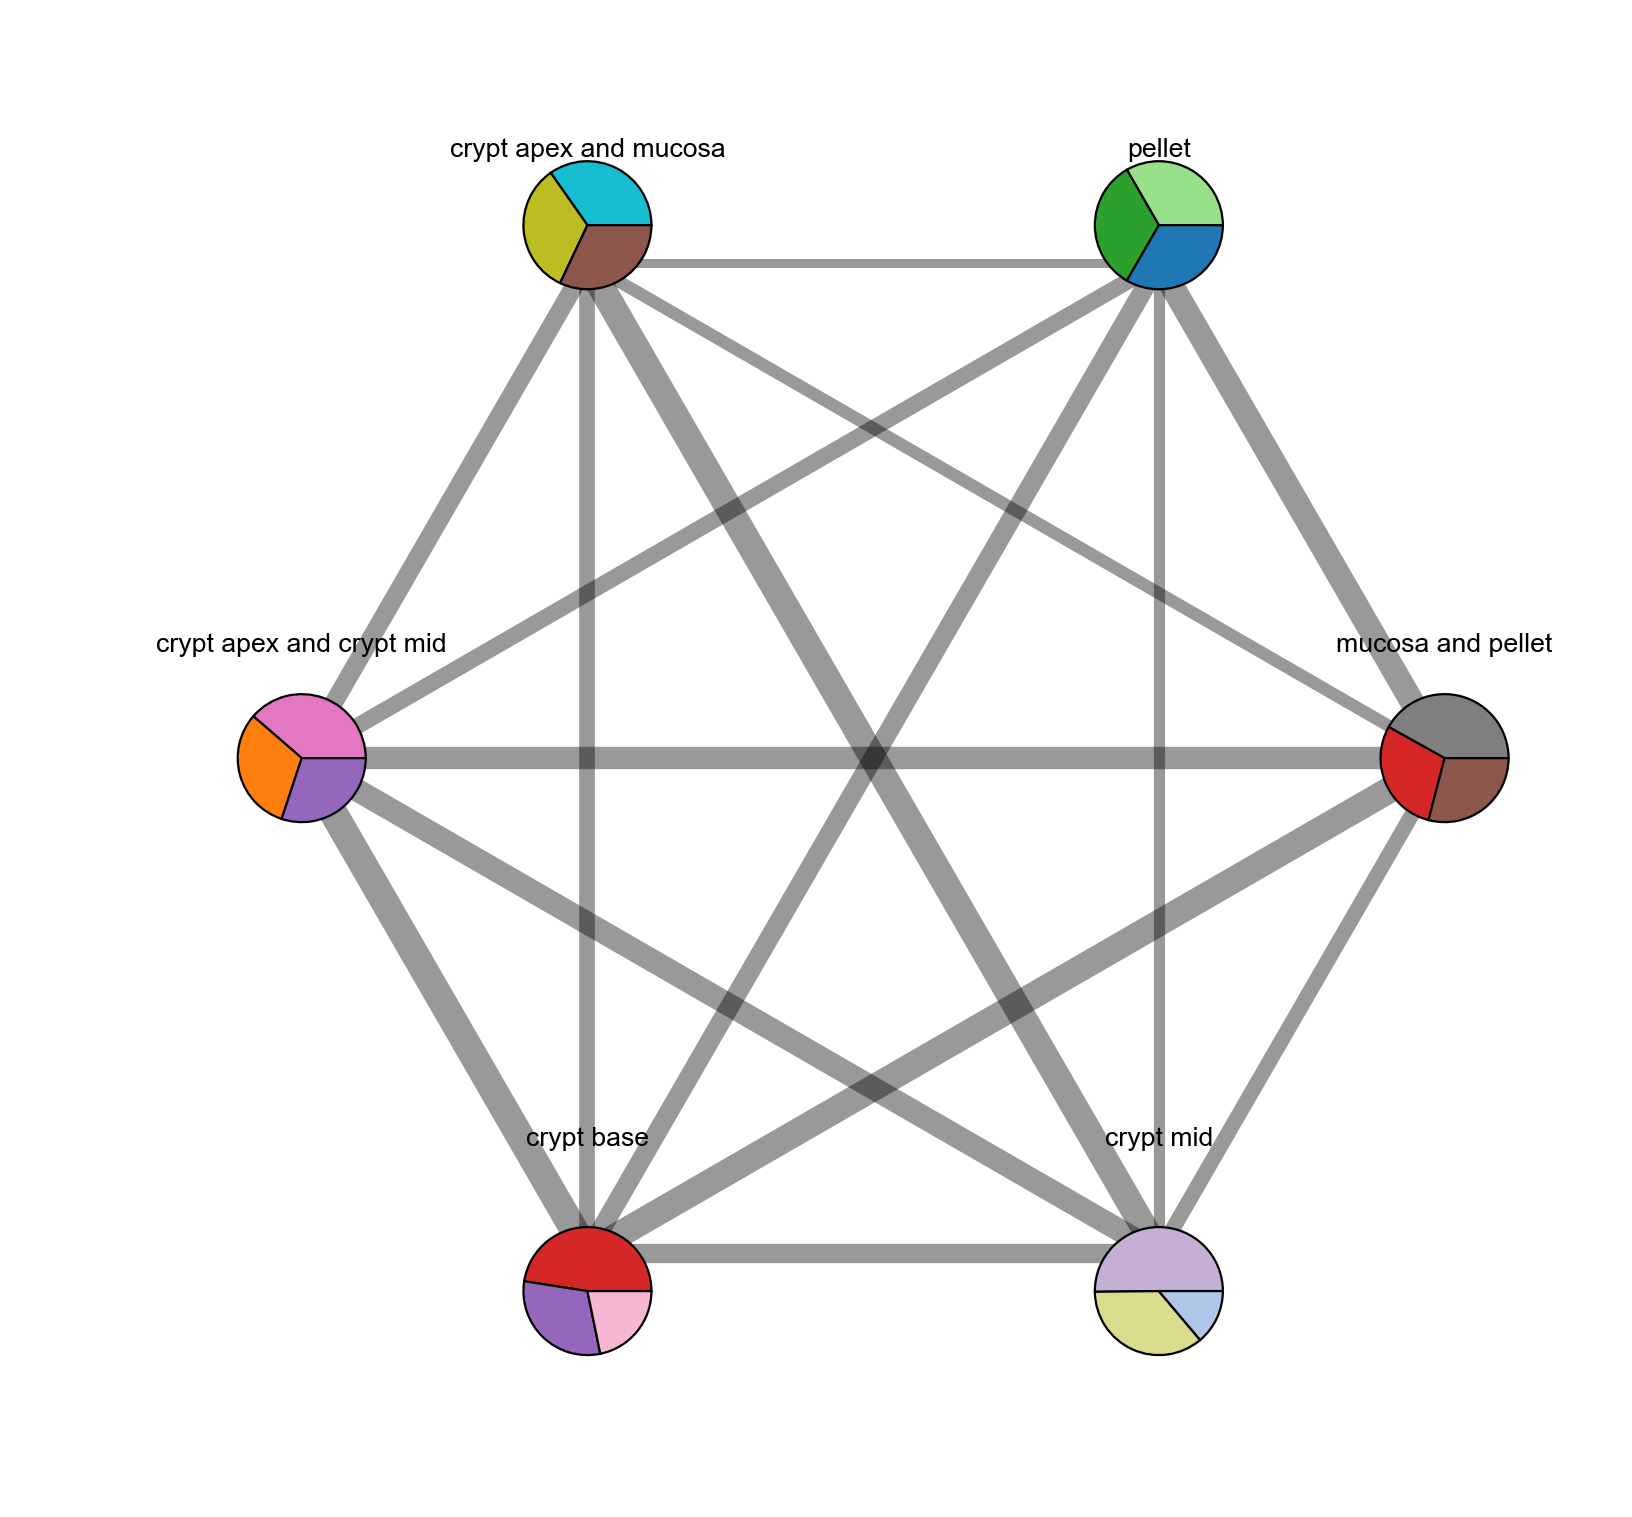

In [16]:
Com = nx.from_pandas_edgelist(node_df, 'n1', 'n2', edge_attr ='euclidean dist.scale')
nn = dict()
for key, value in dist_mean_d_sub.items():
    nn[key] = top5bac_d[value]
HistCom = nn

dist_mean_d_sub = {key: value for key, value in dist_mean_d.items() if value in top5bac_d.keys()}
pos=nx.circular_layout(Com)

fig=plt.figure(figsize=(10,10))
ax=plt.axes([0,0,1,1])
ax.set_aspect('equal')

pos_nodes = nudge(pos, 0, 0.2)  

nx.draw_networkx_edges(Com,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='black',
                       alpha=0.4, ax=ax)
nx.draw_networkx_labels(G, pos=pos_nodes,
                        labels=dist_mean_d_sub,
                        font_color='black')

plt.xlim(-1.5,1.3)
plt.ylim(-1.3,1.3)
plt.axis('off')
f.set_facecolor('w')
plt.box(False)
trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

# Colors
num_bacs_needing_color = []
for k,v in HistCom.items():
    for ik, iv in v.items():
        num_bacs_needing_color.append(ik)
num_bacs_needing_color = list(set(num_bacs_needing_color))
    
NUM_COLORS = len(num_bacs_needing_color)

cm = plt.get_cmap('tab20')

color_to_bac_d = {'Longicatena-Erysipelotrichaceae-Erysipelotrichales-Erysipelotrichia-Firmicutes-Bacteria':'#1f77b4',
               'Dysosmobacter-Oscillospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#aec7e8',
               'Intestinimonas-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#ff7f0e',
               'Akkermansia-Akkermansiaceae-Verrucomicrobiales-Verrucomicrobiae-Verrucomicrobia-Bacteria':'#2ca02c',
               'Clostridium-Clostridiaceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#98df8a',
               'Phocaeicola-Bacteroidaceae-Bacteroidales-Bacteroidia-Bacteroidetes-Bacteria':'#d62728',
               'Mediterraneibacter-Lachnospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#9467bd',
               'Ruthenibacterium-Oscillospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#c5b0d5',
               'Pseudobutyrivibrio-Lachnospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#8c564b',
               'Hungatella-Clostridiaceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#e377c2',
               'Coprococcus-Lachnospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#f7b6d2',
               'Oscillibacter-Oscillospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#7f7f7f',
               'Sodaliphilus-Muribaculaceae-Bacteroidales-Bacteroidia-Bacteroidetes-Bacteria':'#bcbd22',
               'Eubacterium-Eubacteriaceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#dbdb8d',
               'Ruminococcus-Oscillospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria':'#17becf'}
dist_mean_d_sub_reverse = {value:key for key, value in dist_mean_d_sub.items()}
top5bac_fracs_d_nums = {dist_mean_d_sub_reverse[key]:value for key, value in top5bac_fracs_d.items()}

piesize=0.1 #Degree
p2=piesize/2.0

dep_color = dict()
for com in Com:
    xx,yy=trans(pos[com]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])
    a.set_aspect('equal')
    contats = len(HistCom[com].items())
    ColorFrac = []
    for dep,n in sorted(HistCom[com].items(), key=op.itemgetter(1), reverse=True):
        dep_color[dep] = color_to_bac_d[dep]
        ColorFrac.append(dep_color[dep])
    a.pie(top5bac_fracs_d_nums[com], colors = ColorFrac, wedgeprops={"edgecolor":"k"})

plt.show()


# Plot log fold change per region and per taxa level


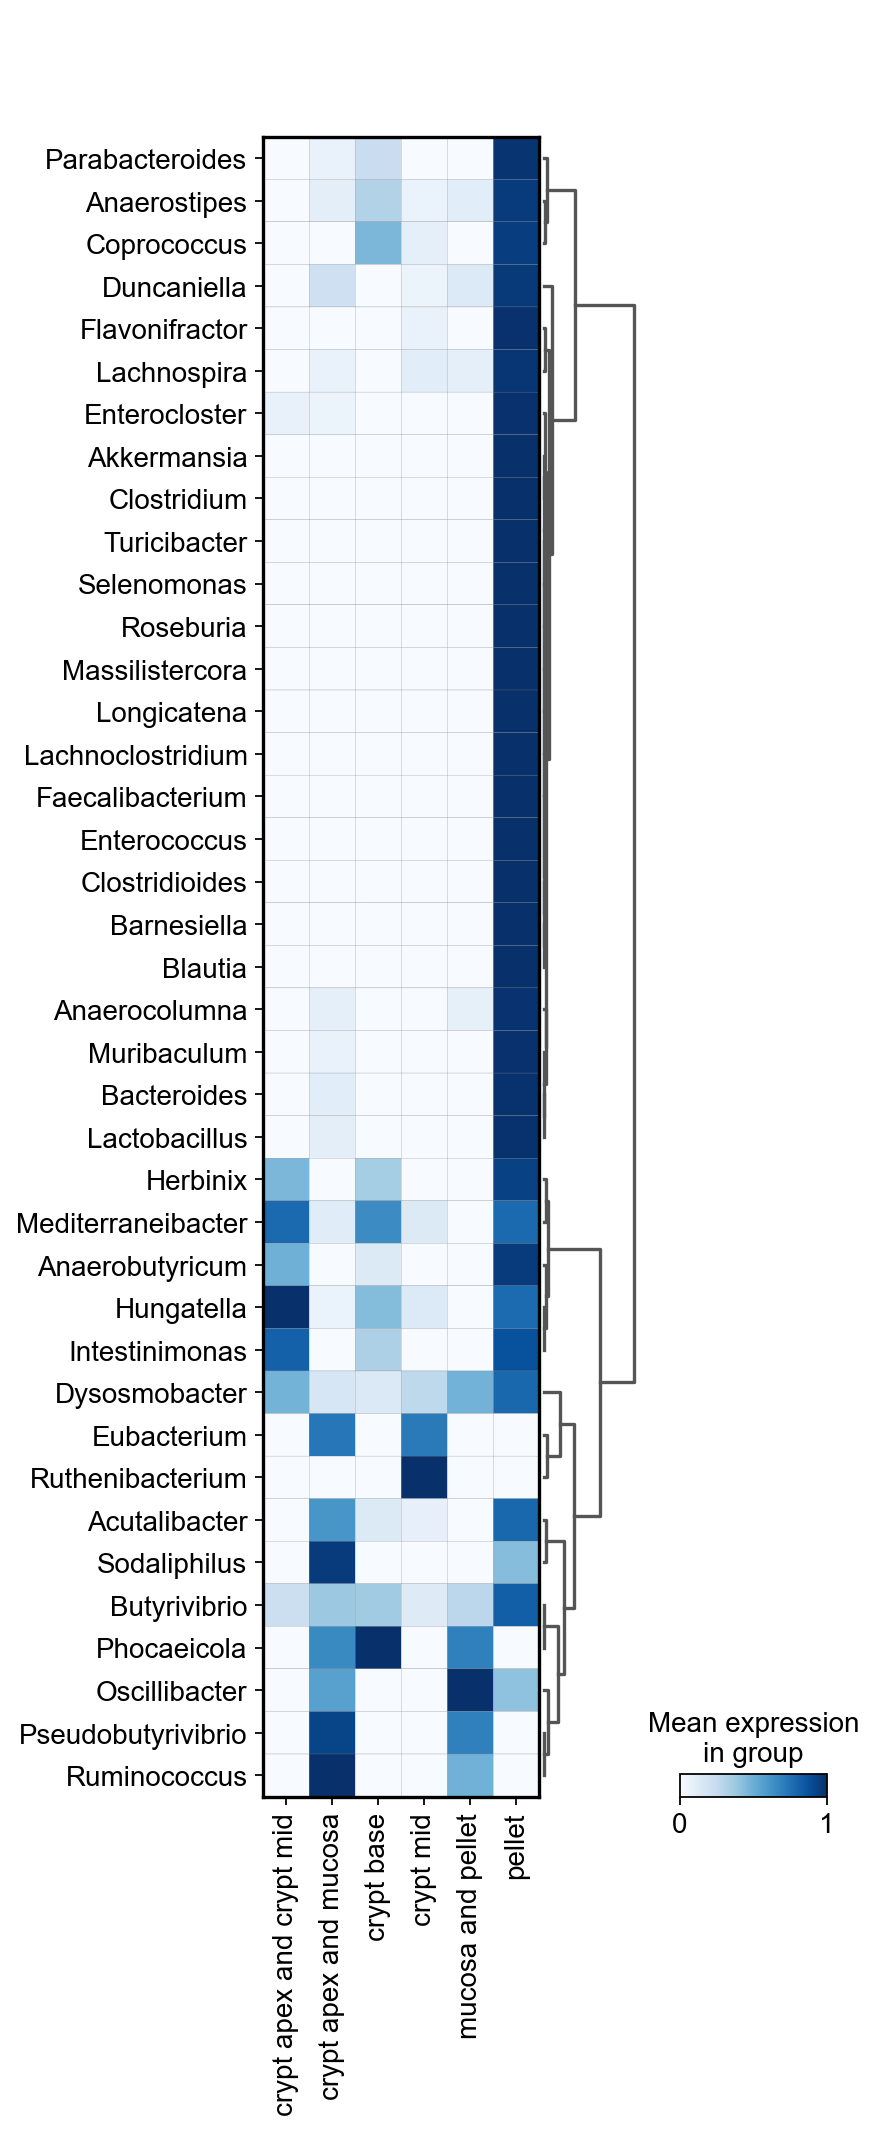

In [17]:
####### WEIGHTED MEAN with DENDROGRAM #######

path = path = ''
fa = sc.read_h5ad(os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad'))
fa.obs['Age'] = '6w'
fa.obs['conditions'] = [i+"_"+str(j) for i,j in zip(fa.obs.Genotype, fa.obs.Age)]

# Only bacteria 
an = fa[:, fa.var_names.isin([i for i in fa.var_names if 'Bacteria' in i])]

# Change names of some bacteria
new_gene_names_in_correct_order = ['Massilistercora-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Massilistercora-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in an.var_names]
new_gene_names_in_correct_order = ['Intestinimonas-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Intestinimonas-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in new_gene_names_in_correct_order]
an.var_names = new_gene_names_in_correct_order
bac_names = [i for i in an.var.index if i.endswith('Bacteria')]
bac_names = [i for i in bac_names if i not in ['Lacrimispora-Lachnospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria',
                                   'Acetobacterium-Eubacteriaceae-Eubacteriales-Clostridia-Firmicutes-Bacteria']]
an = an[:, an.var_names.isin(bac_names)]

for i, tx in enumerate(['genus']):
    
    allap_wt = region_and_bacterial_filtering(an)
    allap_wt.reset_index(inplace=True)
    allap_wt = sc.AnnData(X=allap_wt.iloc[:,2:], obs=allap_wt[['annotation', 'conditions']])
    new = [idi.split('-')[0] for idi in allap_wt.var_names]
    allap_wt.var_names = new
    
    categories_order = ['crypt base', 'crypt mid', 'crypt apex and crypt mid', 'crypt apex and mucosa',
                       'mucosa and pellet', 'pellet']
    
    ax =  allap_wt[allap_wt.obs.annotation.isin(categories_order)]
    
    uu = pd.DataFrame(ax.X, columns=ax.var_names, index=ax.obs['annotation'])
    uu = uu.T  
    
    ax = sc.AnnData(X=uu, obs=pd.DataFrame({'annotation1': uu.index.tolist(),
                                           'annotation': uu.index.tolist()}).set_index('annotation1'))
    ax.obs['annotation'] = ax.obs['annotation'].astype('category')
    sc.pp.scale(ax)
    
    uu = pd.DataFrame(ax.X, columns=ax.var_names, index=ax.obs['annotation'])

    sc.tl.dendrogram(ax, groupby='annotation', linkage_method='ward')
    
    fig_ge = sc.pl.matrixplot(ax,  show = False,
              var_names = ax.var_names,
               groupby = 'annotation', cmap = 'Blues',
            swap_axes = False, vmin = 0, standard_scale = 'var', dendrogram=True) 
